# Aula: O "E se os dados forem complexos?" (Deep Learning)

Nas aulas passadas, vimos dois mundos:

1.  **IA Simbólica (Sistemas Especialistas):** Nós, humanos, escrevemos as regras (`SE... ENTÃO...`). Funciona bem, mas é trabalhoso e "frágil".
2.  **Machine Learning Clássico (Ex: Árvore de Decisão):** O modelo aprende as regras a partir de *dados tabelados*. Nós ainda precisamos fazer a **Engenharia de Features**, ou seja, dizer ao modelo em quais colunas olhar (ex: `folhas`, `solo`, `praga`).

**A Grande Pergunta (A Ponte):**
E se quiséssemos que nosso sistema de diagnóstico de plantas aprendesse *diretamente da foto*? 

Uma foto de 100x100 pixels tem 10.000 pixels. Se for colorida (RGB), tem 30.000 features. Como uma Árvore de Decisão saberia quais desses 30.000 pixels importam? Ela não conseguiria. Precisamos de um modelo que *aprenda as features sozinho*.

É aqui que entra o **Deep Learning (Aprendizado Profundo)**.

## Módulo 1: O Que é Deep Learning? (Teoria)

**Deep Learning** é um subcampo do Machine Learning baseado em **Redes Neurais Artificiais**.

* **Rede Neural:** Inspirada nos neurônios do cérebro, é uma estrutura de várias camadas. Cada "neurônio" (ou nó) recebe dados, faz um cálculo e passa o resultado para frente.
* **"Deep" (Profundo):** Refere-se a redes neurais com *muitas* camadas (dezenas ou centenas). A profundidade permite que a rede aprenda padrões cada vez mais complexos.

### A Rede Neural para "Ver": A CNN

Para imagens, usamos um tipo especial de rede neural chamado **Rede Neural Convolucional (CNN ou ConvNet)**. 

A CNN imita o córtex visual humano. Ela não olha a imagem inteira de uma vez. Ela usa "filtros" (ou *kernels*) para escanear a imagem pedaço por pedaço, aprendendo a identificar padrões:

1.  **Camadas Iniciais:** Aprendem features simples (bordas, cantos, cores).
2.  **Camadas Intermediárias:** Combinam as features simples para aprender texturas, formas (círculos, quadrados).
3.  **Camadas Finais:** Combinam as formas para aprender objetos complexos (um olho, uma roda, uma "folha amarelada").

Ela faz a **Engenharia de Features automaticamente**.

## Módulo 2: O "Hello, World!" do Deep Learning (MNIST)

Vamos construir uma CNN para o problema mais famoso do Deep Learning: classificar dígitos escritos à mão do dataset **MNIST**.

**Nossas Ferramentas:**
* **TensorFlow:** A biblioteca de Deep Learning mais popular do mundo (criada pelo Google).
* **Keras:** Uma interface de alto nível (e fácil de usar) que *vem dentro* do TensorFlow para construir redes neurais como se fossem blocos de LEGO.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(f"Versão do TensorFlow instalada: {tf.__version__}")

Versão do TensorFlow instalada: 2.20.0


### Passo 2: Carregar e Preparar os Dados

O MNIST é um dataset de 60.000 imagens de treino e 10.000 de teste (tamanho 28x28 pixels).

In [24]:
# O Keras já vem com o dataset MNIST embutido
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Formato dos dados de treino (imagens): {x_train.shape}")
print(f"Formato dos dados de treino (rótulos): {y_train.shape}")
print(f"Temos {x_train.shape[0]} imagens de treino e {x_test.shape[0]} de teste.")

Formato dos dados de treino (imagens): (60000, 28, 28)
Formato dos dados de treino (rótulos): (60000,)
Temos 60000 imagens de treino e 10000 de teste.


### Passo 3: Pré-Processamento

As redes neurais funcionam melhor com números pequenos. Vamos **normalizar** os pixels (que vão de 0 a 255) para um intervalo de **0 a 1**.

Além disso, a CNN espera que a imagem diga quantos "canais de cor" ela tem. Para o MNIST (tons de cinza), o canal é 1. Vamos formatar de `(28, 28)` para `(28, 28, 1)`.

Formato dos dados DEPOIS do pré-processamento: (60000, 28, 28, 1)

Valor máximo em um pixel: 1.0
Valor mínimo em um pixel: 0.0


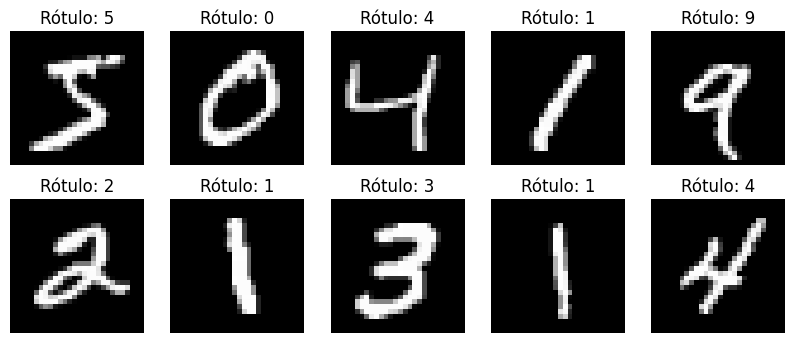

In [25]:
# Normalização: dividir todos os pixels por 255
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Adicionar a dimensão do canal (de 60000, 28, 28 -> 60000, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Formato dos dados DEPOIS do pré-processamento:", x_train.shape)

# Vamos ver como ficou uma imagem (agora com valores entre 0 e 1)
print("\nValor máximo em um pixel:", np.max(x_train[0]))
print("Valor mínimo em um pixel:", np.min(x_train[0]))

# Visualizar alguns exemplos
plt.figure(figsize=(10, 4))
for i in range(10): # Mostrar os 10 primeiros
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="gray")
    plt.title(f"Rótulo: {y_train[i]}")
    plt.axis("off")
plt.show()

## Módulo 3: Construindo a CNN (O "Cérebro")

Vamos construir nosso modelo em Keras. É como empilhar blocos de LEGO:

1.  **`keras.Sequential`**: É a nossa "base" de LEGO. Diz que vamos empilhar camadas uma em cima da outra.
2.  **`layers.Conv2D`**: A Camada Convolucional (a "lupa" que varre a imagem). Ela aprende as features.
3.  **`layers.MaxPooling2D`**: A Camada de Pooling (o "resumidor"). Ela reduz o tamanho da imagem para focar no que é importante.
4.  **`layers.Flatten`**: O "achatador". Transforma o mapa 2D de features em um vetor 1D.
5.  **`layers.Dense`**: A Rede Neural "normal" no final. Ela pega o vetor de features e toma a decisão (classifica).
6.  **`layers.Dense(10, activation='softmax')`**: A camada de saída. Tem 10 neurônios (um para cada dígito, 0-9) e a ativação `softmax` transforma os valores em probabilidades (ex: 90% de chance de ser um '7').

In [26]:
model = keras.Sequential([
    # Define o formato da entrada (nossas imagens 28x28x1)
    keras.Input(shape=(28, 28, 1)),
    
    # Primeira camada Convolucional: 32 filtros (lupas) de tamanho 3x3
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    
    # Camada de "resumo" (Pooling)
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Segunda camada Convolucional: 64 filtros (aprende features mais complexas)
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    
    # Outro "resumo"
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # "Achata" o resultado para alimentar a rede final
    layers.Flatten(),
    
    # Camada "Densa" (tradicional) com 128 neurônios para tomar a decisão
    layers.Dense(128, activation="relu"),
    
    # Camada de Saída: 10 neurônios (0 a 9) com ativação softmax (probabilidades)
    layers.Dense(10, activation="softmax")
])

# O .summary() é fantástico para entender a arquitetura e ver como 
# o tamanho da imagem diminui e o número de features aumenta.
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## Módulo 4: Treinamento e Avaliação

Agora que o "cérebro" está montado, precisamos de 3 coisas:

1.  **`loss` (Função de Perda):** A "prova" do modelo. Mede o quão errada está a previsão. `sparse_categorical_crossentropy` é o padrão para classificação com números inteiros (0, 1, 2...).
2.  **`optimizer` (Otimizador):** O "professor". É o algoritmo que ajusta os pesos da rede para diminuir o erro. `adam` é o mais usado e recomendado.
3.  **`metrics` (Métricas):** O que nós, humanos, queremos ver. A `accuracy` (acurácia) é a mais simples.

In [27]:
# Compilando o modelo
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Treinando o modelo!
print("Iniciando o treinamento da CNN...")

# epochs: Quantas vezes o modelo vai "ver" o dataset inteiro
# validation_split: Separa 10% dos dados de treino para testar o modelo a cada época
history = model.fit(x_train, y_train, 
                    epochs=5, 
                    batch_size=64, # Treina em "lotes" de 64 imagens por vez
                    validation_split=0.1)

print("\nTreinamento concluído!")

Iniciando o treinamento da CNN...
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8890 - loss: 0.3926 - val_accuracy: 0.9858 - val_loss: 0.0516
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9835 - loss: 0.0520 - val_accuracy: 0.9857 - val_loss: 0.0492
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9898 - loss: 0.0324 - val_accuracy: 0.9890 - val_loss: 0.0416
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9916 - loss: 0.0257 - val_accuracy: 0.9920 - val_loss: 0.0354
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.9892 - val_loss: 0.0430

Treinamento concluído!


### Avaliando o Modelo

Agora a parte mais importante: testar o modelo em dados que ele **nunca viu** (o `x_test`). Isso mede o quão bem ele realmente aprendeu a generalizar.


Acurácia no teste (dados inéditos): 98.86%
Perda (Loss) no teste: 0.0352


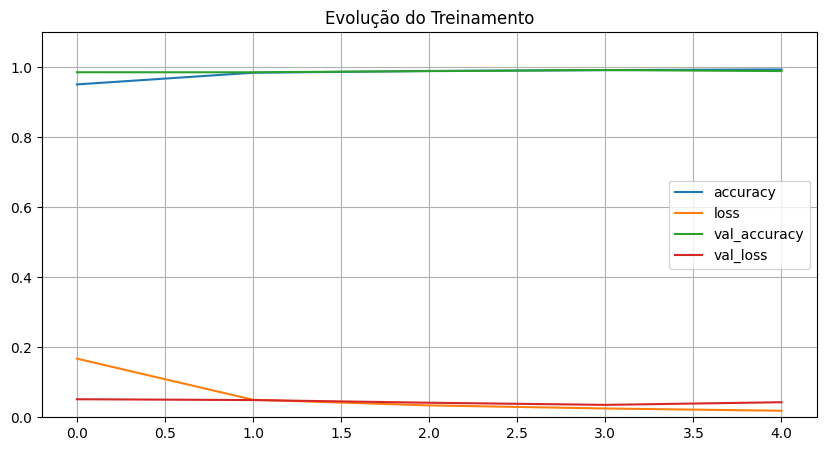

In [28]:
# Avaliando no dataset de teste
score = model.evaluate(x_test, y_test, verbose=0)

print(f"\nAcurácia no teste (dados inéditos): {score[1] * 100:.2f}%")
print(f"Perda (Loss) no teste: {score[0]:.4f}")

# Plotando o histórico de treino (acurácia subindo e perda caindo)
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1) # Ajustar o eixo Y de 0 a 1.1
plt.title("Evolução do Treinamento")
plt.show()

Testando o modelo em 10 imagens de teste...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


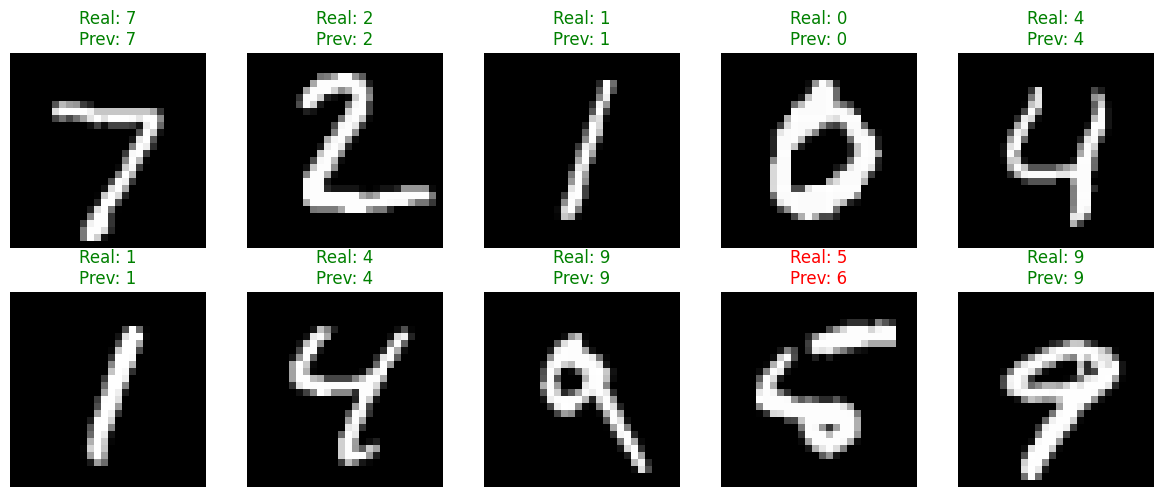

In [29]:
# Vamos ver algumas previsões na prática!
print("Testando o modelo em 10 imagens de teste...")

# Pegar as 10 primeiras imagens de teste
imagens_teste = x_test[:10]
rotulos_reais = y_test[:10]

# Pedir ao modelo para prever todas de uma vez
previsoes_raw = model.predict(imagens_teste)

plt.figure(figsize=(12, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(imagens_teste[i].reshape(28, 28), cmap="gray")
    
    # A previsão 'raw' é um array de 10 probabilidades
    # Usamos np.argmax para pegar o índice da MAIOR probabilidade
    previsao_digito = np.argmax(previsoes_raw[i])
    real_digito = rotulos_reais[i]
    
    # Colocar em verde se acertou, vermelho se errou
    cor = 'green' if previsao_digito == real_digito else 'red'
    plt.title(f"Real: {real_digito}\nPrev: {previsao_digito}", color=cor)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

---

## Módulo 5: O Próximo Nível (Desafio CIFAR-10)

O MNIST é fácil. Os dígitos são centralizados e o fundo é preto. O que acontece quando as imagens são do mundo real, coloridas e complexas? 

Vamos usar o dataset **CIFAR-10**. Ele tem 10 classes (avião, carro, pássaro, gato, cervo, cachorro, sapo, cavalo, navio, caminhão) em imagens 32x32 **coloridas** (32x32x3).

Este é um ótimo proxy para o nosso problema das plantas (imagens complexas e coloridas).

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step
Formato treino CIFAR: (50000, 32, 32, 3)


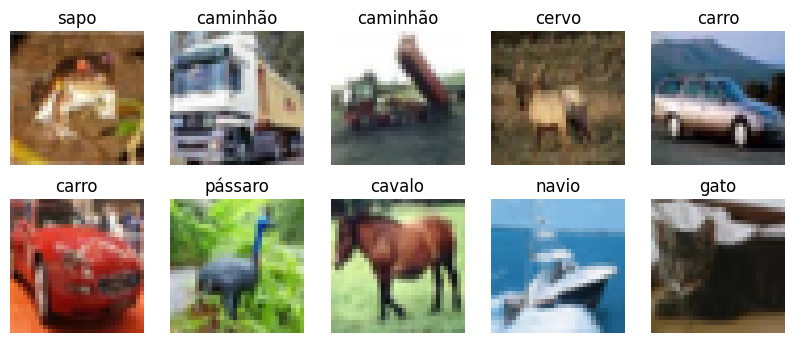

In [30]:
# Carregando o CIFAR-10
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

print(f"Formato treino CIFAR: {x_train_cifar.shape}") # Note o '3' no final (RGB)

# Definir os nomes das classes para visualização
nomes_classes_cifar = ['avião', 'carro', 'pássaro', 'gato', 'cervo', 
                       'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# Pré-processamento: Apenas normalizar (já está no formato certo 32x32x3)
x_train_cifar = x_train_cifar.astype("float32") / 255.0
x_test_cifar = x_test_cifar.astype("float32") / 255.0

# Visualizar os dados (são bem mais difíceis!)
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_cifar[i]) # imshow lida com RGB automaticamente
    plt.title(nomes_classes_cifar[y_train_cifar[i][0]])
    plt.axis("off")
plt.show()

### Desafio para os Alunos:

Copie a arquitetura do modelo que criamos para o MNIST e tente aplicá-la ao CIFAR-10.

**Dicas:**
1.  Mude o `keras.Input()` para `shape=(32, 32, 3)`.
2.  A camada de saída `Dense` continua com `10` neurônios e `softmax`.
3.  O `loss` e o `optimizer` podem ser os mesmos.
4.  **Não se frustre!** A acurácia será bem menor (talvez 60-70%). Isso é normal e mostra que problemas do mundo real exigem redes mais profundas, mais dados e mais técnicas (como `Dropout`).

In [31]:
# Solução do Desafio (Modelo para CIFAR-10)

model_cifar = keras.Sequential([
    keras.Input(shape=(32, 32, 3)), # MUDANÇA 1: Formato da entrada
    
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    # Vamos adicionar uma camada de Dropout para ajudar a generalizar
    # Dropout "desliga" 50% dos neurônios aleatoriamente durante o treino
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5), 
    
    layers.Dense(10, activation="softmax") # MUDANÇA 2: Continua 10 (10 classes)
])

model_cifar.summary()

# Compilar
model_cifar.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

# Treinar (Vamos treinar por mais épocas, pois é um problema mais difícil)
print("\nIniciando o treinamento da CNN para CIFAR-10...")
history_cifar = model_cifar.fit(x_train_cifar, y_train_cifar, 
                                batch_size=64, 
                                epochs=10, # Mais épocas
                                validation_data=(x_test_cifar, y_test_cifar))

print("Treinamento CIFAR concluído!")

# Avaliar
score_cifar = model_cifar.evaluate(x_test_cifar, y_test_cifar, verbose=0)
print(f"\nAcurácia no teste CIFAR-10: {score_cifar[1] * 100:.2f}%")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento da CNN para CIFAR-10...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3096 - loss: 1.8828 - val_accuracy: 0.5306 - val_loss: 1.3160
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5124 - loss: 1.3670 - val_accuracy: 0.6047 - val_loss: 1.1314
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5694 - loss: 1.2130 - val_accuracy: 0.6159 - val_loss: 1.0815
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6018 - loss: 1.1259 - val_accuracy: 0.6361 - val_loss: 1.0322
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6255 - loss: 1.0568 - val_accuracy: 0.6580 - val_loss: 0.9651
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6501 - loss: 0.9974 - val_accuracy: 0.6697 - val_loss: 0.9447
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6635 - loss: 0.9542 - val_accuracy: 0.6850 - val_loss: 0.9059
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step -

### Conclusão da Aula

Hoje vimos a diferença entre ML clássico e Deep Learning.

* O ML Clássico precisa de **Engenharia de Features** (nós dizemos o que é importante).
* O Deep Learning (com CNNs) faz a **Extração Automática de Features** (ele aprende o que é importante diretamente dos pixels).

Para o nosso problema de **diagnóstico de plantas**, o próximo passo seria coletar milhares de fotos de plantas, rotular cada uma com o diagnóstico correto e treinar uma CNN (provavelmente muito maior que a do CIFAR-10) para classificar essas imagens automaticamente.

A partir daqui, poderíamos conectar o output desse modelo de Deep Learning (ex: `['folha_amarela', 'praga_cochonilha']`) ao nosso **Sistema Especialista** da primeira aula, que usaria essa informação para recomendar uma solução. Isso é um **Sistema Híbrido**.